# Regressioni per dati di conteggio

- Abbiamo un dataset di 3874 soggetti di cui vogliamo spiegare il numero di visite annue dal medico in funzione dei seguenti predittori: il numero di giorni passati in ospedale, l'età, l'essere disoccupato, l'essere donna, l'avere figli, gli anni di istruzione.
- **Steps**:
    
    - Importazione dataset e calcolo di media e varianza dei conteggi osservati
    - Plot di conteggi osservati vs conteggi attesi
    - Regressione di Poisson
    - Due esempi di test per verificare l'eventuale presenza di *overdispersion*
    - Regressione binomiale negativa
    - Test sul parametro di *overdispersion* (rapporto tra verosimiglianze)
    - Interpretazione degli effetti

In [1]:
%pylab inline

import pandas as pd
import seaborn as sb
import statsmodels.api as sm


Populating the interactive namespace from numpy and matplotlib


/Users/davidepassaretti/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
my_df = pd.read_csv('rwm1984.csv')

In [3]:
my_df.head()

,docvis,hospvis,edlevel,age,outwork,female,kids,hhninc,educ
0,1,0,3,54,0,0,0,3.050,15.0
1,0,0,1,44,1,1,0,3.050,9.0
2,0,0,1,58,1,1,0,1.434,11.0
3,7,2,1,64,0,0,0,1.500,10.5
4,6,0,3,30,1,0,0,2.400,13.0


In [4]:
y = my_df['docvis']

In [5]:
x = my_df.drop('docvis', 1) # togliamo la variabile di risposta
x = x.drop('edlevel', 1) # togliamo il livello di istruzione, visto che è fortemente associato agli anni di istruzione

In [6]:
x['constant'] = 1

In [7]:
x.head()

,hospvis,age,outwork,female,kids,hhninc,educ,constant
0,0,54,0,0,0,3.050,15.0,1
1,0,44,1,1,0,3.050,9.0,1
2,0,58,1,1,0,1.434,11.0,1
3,2,64,0,0,0,1.500,10.5,1
4,0,30,1,0,0,2.400,13.0,1


In [8]:
{'media' : np.mean(y), 'varianza' : np.var(y)}

{'media': 3.1628807434176562, 'varianza': 39.377445082834946}

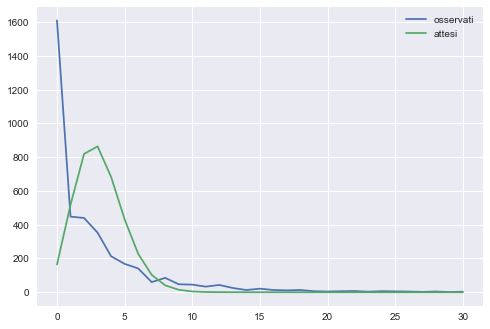

In [9]:
import scipy.stats as stat
conteggi_osservati = y.value_counts().sort_index(0)[:31]
conteggi_attesi = stat.poisson.pmf(arange(31), np.mean(y)) * y.count()
plt.subplot()
plt.plot(arange(31), conteggi_osservati, label="osservati")
plt.plot(arange(31), conteggi_attesi, label="attesi")
plt.legend()

# Poisson regression

In [10]:
poisson_regression = sm.Poisson(y, x).fit(method = 'newton')

Optimization terminated successfully.
         Current function value: 3.935901
         Iterations 27


In [11]:
poisson_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                 docvis   No. Observations:                 3874
Model:                        Poisson   Df Residuals:                     3866
Method:                           MLE   Df Model:                            7
Date:                Wed, 25 Oct 2017   Pseudo R-squ.:                 0.07233
Time:                        11:24:06   Log-Likelihood:                -15248.
converged:                       True   LL-Null:                       -16437.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hospvis        0.1360      0.005     26.399      0.000       0.126       0.146
age            0.0192      0.001     19.894      0.000       0.017       0.021
outwork        0.2003      0.022      9.088      0.000       0.157       0.244
female         0.2844      0.021     13.391      0.000       0.243       0.326
kids          -0.1311      0.022     -6.086      0.000      -0.173      -0.089
hhninc        -0.0733      0.008     -9.723      0.000      -0.088      -0.059
educ          -0.0127      0.005     -2.652      0.008      -0.022      -0.003
constant       0.4123      0.078      5.273      0.000       0.259       0.566
==============================================================================
"""

## TEST per l'*overdispersion*: SCORE test

In [12]:
# calcolo i conteggi predetti (attesi)
mu = poisson_regression.predict()

# calcolo la statistica test
z_stat = ((y - mu)**2 - y)/(mu * sqrt(2))

# Bisogna testare se z_stat abbia media uguale a zero tramite un t-test
stat.ttest_1samp(z_stat, 0)

Ttest_1sampResult(statistic=6.6035991083010037, pvalue=4.558082151684842e-11)

## TEST per l'*overdispersion*: Lagrange-Multiplier test 

In [13]:
# clacolo la statistica test
obs = y.count()
mmu = np.mean(mu)
nybar = obs*mmu
musq = mu*mu 
mu2 = np.mean(musq)*obs
chival = (mu2 - nybar)**2/(2*mu2) 

# Il p-value è calcolato sulla distribuzione Chi-quadro
chival, 1 - stat.chi2.cdf(chival,1)

(14293.555796442171, 0.0)

# Negative binomial regression

In [14]:
nb_regression = sm.NegativeBinomial(y, x).fit(disp = False)

In [15]:
nb_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                 docvis   No. Observations:                 3874
Model:               NegativeBinomial   Df Residuals:                     3866
Method:                           MLE   Df Model:                            7
Date:                Wed, 25 Oct 2017   Pseudo R-squ.:                 0.02022
Time:                        11:24:07   Log-Likelihood:                -8254.8
converged:                       True   LL-Null:                       -8425.2
                                        LLR p-value:                 1.186e-69
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hospvis        0.4787      0.061      7.860      0.000       0.359       0.598
age            0.0207      0.003      8.081      0.000       0.016       0.026
outwork        0.1769      0.060      2.931      0.003       0.059       0.295
female         0.3622      0.056      6.457      0.000       0.252       0.472
kids          -0.1313      0.057     -2.313      0.021      -0.243      -0.020
hhninc        -0.0555      0.016     -3.383      0.001      -0.088      -0.023
educ          -0.0239      0.013     -1.892      0.058      -0.049       0.001
constant       0.3162      0.206      1.538      0.124      -0.087       0.719
alpha          2.1557      0.068     31.802      0.000       2.023       2.289
==============================================================================
"""

## Test sul rapporto tra Verosimiglianze 

Bisogna ora capire se l'utilizzo del Modello Binomiale Negativo ha portato vantaggi rispetto al Modello di Poisson. Per valutare ciò, ci avvarremo di un test che confronta le devianze dei due modelli. Nel caso la devianza del modello Binomiale Negativo sia di gran lunga inferiore a quella del modello di Poisson (*p*-value < 0.05), allora manterremo il Binomiale Negativo.

In [16]:
# Devianza Poisson
devianza_poiss = -2 * poisson_regression.llf

# Devianza Negative Binomial
devianza_nb = -2 * nb_regression.llf

# Differenza in devianze
g = devianza_poiss - devianza_nb

# Il p-value è calcolato su una distribuzione Chi-quadrato con 1 grado di libertà
chival, 1 - stat.chi2.cdf(g,1)

(14293.555796442171, 0.0)

# Interpretazione dei coefficienti

Abbiamo quindi il nostro modello Binomiale Negativo. 

L'interpretazione dei coefficienti (che sarebbe analoga in caso di modello di Poisson) si basa sul fatto che abbiamo a che fare con un modello log-lineare. 

**_La relazione tra ciascun predittore e la variabile di risposta va interpretata mantenendo costanti tutti gli altri predittori, poiché ci troviamo in un modello con più di un predittore_**.

Iniziamo col dire che la variabile **educ** non contribuisce significativamente alle variazioni della variabile di risposta **docvis** per alpha = 0.05. Potrebbe comunque avere un effetto negativo non del tutto trascurabile (*p*-value = 0.058).

Le variabili **kids** e **hhninc** sono negativamente associate a **docvis**: avere dei bambini fa decrescere in media il numero delle visite annuali dal medico di un fattore pari a exp(-0.1313) = 0.8769, cioè un decremento del 12.30%, mentre un incremento di un marco tedesco nel reddito familiare annuale fa decrescere in media il numero delle visite di un fattore pari a exp(-0.0555) = 0.9460, ossia un decremento del 5.40%.

Gli altri 4 predittori significativi (**hospvis**, **age**, **outwork**, **female**) sono positivamente associati a **docvis**: un giorno in più in ospedale durante l'anno è associato ad un incremento medio delle visite dal medico di un fattore pari a  exp(0.4787) = 1.6140, ossia un incremento del 61.40% (sembra piuttosto legittimo); ogni anno di età in più contribuisce ad aumentare in media le visite dal medico di un fattore pari a exp(0.0207) = 1.0209, cioè un incremento del 2.09%; essere senza lavoro aumenta in media le visite di un fattore pari a exp(0.1769) = 1.1935, cioè un incremento del 19.35%; essere donne aumenta in media le visite annuali dal medico di un fattore pari a exp(0.3622) = 1.4365, ossia un incremento del 43.65%.